In [ ]:
#@title Importing used packages
import torch
import torchvision
import pickle

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output 

!pip install torchinfo
clear_output()

from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

Generative models aim to generate datapoints from the distribution of a given dataset.

Generative Adversarial Nets (**GANs**) are such models which have been proposed by Ian Goodfellow in 2014. They rely on a generator/discriminator architecture where the discriminator tries to distinguish between real images coming from our dataset and fake generated images, and the generator tries to generate images close to the ones in our dataset in order to fool the discriminator.

In the paper [Improving GANs Using Optimal Transport](https://arxiv.org/abs/1803.05573), Tim Salimans \& al introduce a new optimal transport inspired objective function to train **GANs**.

Below, we aim to define and train such Optimal Transport enhanced **GANs** on the MNIST dataset.

The architecture below is what seemed to work best for us.

The generator of our Optimal Transport enhanced GAN has 5 layers, a linear layer to increase the size of our input noise, and 4 convolutionnal layers (kernel size of 5, stride 5 with padding).

In this Optimal Transport enhanced GAN, the discriminator aims to embed our images. Below, the discriminator has 2 linear layers.

In [ ]:
#@title Define Optimal transport enhanced GAN
class OT_GAN(nn.Module):
  '''Class to Implement Optimal Transport enhance GAN'''
  def __init__(self, device, input_img_channels = 1, gen_feature_channels = [8192, 256, 128, 64, 32], hidden_embed = 2048, cost_embedding_size = 4096,
               input_size = 100, output_size = 32, nb_steps_sinkhorn = 100, entropy_regularization = 500):
    
    super().__init__()
    
    # Added
    self.output_channels = 1
    self.kernel_size = 5
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    self.padding = int((self.kernel_size-1)/2)
    #
    
    self.device = device
    self.gdim = gen_feature_channels
    self.output_size = output_size
    
    #Generator layers
    self.gfc=nn.Linear(input_size, self.gdim[0])
    self.gconv1 = nn.Conv2d(self.gdim[1], self.gdim[1], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv2 = nn.Conv2d(self.gdim[2], self.gdim[2], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv3 = nn.Conv2d(self.gdim[3], self.gdim[3], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv4 = nn.Conv2d(self.gdim[4], self.output_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding)
    
    
    #Sinkhorn divergence parameters
    self.nb_steps = nb_steps_sinkhorn
    self.alpha = entropy_regularization

    
    #Learned cost function layers
    self.fc1 = nn.Linear(output_size*output_size, hidden_embed)
    self.fc2 = nn.Linear(hidden_embed,cost_embedding_size)
    self.cos_sim = torch.nn.CosineSimilarity(0)

    self.relu = nn.ReLU()
    self.glu = nn.GLU(dim=1)
    self.sigmoid = nn.Sigmoid()

  #######################################
  #return optimizers
  #######################################
  def init_optimizers(self):
    '''Define optimizer (outside of __init__ in case we import weights)'''
    self.generator_optimizer = torch.optim.Adam([{"params" : self.gfc.parameters()},
                                                 {"params" : self.gconv1.parameters()},
                                                 {"params" : self.gconv2.parameters()},
                                                 {"params" : self.gconv3.parameters()},
                                                 {"params" : self.gconv4.parameters()}],
                                               lr=0.0005,
                                               betas=(0.5, 0.999))
    
    self.discrim_optimizer = torch.optim.Adam([{"params" : self.fc1.parameters()},
                                               {"params" : self.fc2.parameters()}],
                                             lr=0.0005,
                                               betas=(0.5, 0.999))
    
    return(self.generator_optimizer,self.discrim_optimizer)


  #######################################
  #Pairwise cosine distance after embedding
  #######################################
  def embed_for_cost(self,x):
    '''Function to embed a batch of images and normalize result to compute cost function
    x : batch of images'''
    embed_x = torch.flatten(x,start_dim = 1)
    embed_x = self.fc1(embed_x)
    embed_x = self.relu(embed_x)
    embed_x = self.fc2(embed_x)

    normalized_embed_x = torch.nn.functional.normalize(embed_x, p=2)
    return(normalized_embed_x)
  
  
  def pw_cosine_distance(self, normalized_embedded_batch_x, normalized_embedded_batch_y):
   '''Given a batch of (normalized) vectors, compute the pairwise cosine distance between the vectors of the first batch and of the second batch
   embedded_batch_x : batch of 1d vectors
   embedded_batch_y : second batch of 1d vectors with which to compute pairwise cosine distance'''
   result = torch.mm(normalized_embedded_batch_x, normalized_embedded_batch_y.T)
   result *= -1 
   result += 1
   return result

  #######################################
  #Sinkhorn
  #######################################

  def sinkhorn(self,cost_matrix):
    '''Implement Sinkhorn's divergence algorithm for soft matching
    cost_matrix : cost matrix (between two batches)'''
    cloned_cost_matrix = cost_matrix.clone().detach()
    K = torch.exp(-cloned_cost_matrix/self.alpha)
    n = cost_matrix.shape[0]
    u = (torch.ones(n)/n).to(device)
    
    normalized_one_vector = (torch.ones(n)/n).to(device)

    v = normalized_one_vector / torch.matmul(K.T,u)

    for i in range(self.nb_steps) :
      u = normalized_one_vector / torch.matmul(K,v)
      v = normalized_one_vector / torch.matmul(K.T,u)
    
    transport_plan = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))

    return transport_plan
  

  #######################################
  #Compute OT distance between batches
  #######################################


  def loss_fct(self, x0, x1, y0, y1, discrim = False):
    '''Compute loss function between batches
    x0 and x1 : 2 batches of real images
    y. and y1 : 2 batches of generated images
    '''
    #First step, is to get normalized embedding of each of the batch images
    embed_x0 = self.embed_for_cost(x0)
    embed_x1 = self.embed_for_cost(x1)
    embed_y0 = self.embed_for_cost(y0)
    embed_y1 = self.embed_for_cost(y1)

    #Now, get pairwise cosine distance between the batches of interest
    cost_matrix_1 = self.pw_cosine_distance(embed_x0,embed_y0)
    cost_matrix_2 = self.pw_cosine_distance(embed_x0,embed_y1)
    cost_matrix_3 = self.pw_cosine_distance(embed_x1,embed_y0)
    cost_matrix_4 = self.pw_cosine_distance(embed_x1,embed_y1)
    cost_matrix_5 = self.pw_cosine_distance(embed_x0,embed_x1)
    cost_matrix_6 = self.pw_cosine_distance(embed_y0,embed_y1)
    
    #Get OT plan and compute distance for each pair of batches
    ot_plan_1 = self.sinkhorn(cost_matrix_1)
    dist_1 = torch.trace(torch.matmul(ot_plan_1, cost_matrix_1.T))

    ot_plan_2 = self.sinkhorn(cost_matrix_2)
    dist_2 = torch.trace(torch.matmul(ot_plan_2, cost_matrix_2.T))

    ot_plan_3 = self.sinkhorn(cost_matrix_3)
    dist_3 = torch.trace(torch.matmul(ot_plan_3, cost_matrix_3.T))

    ot_plan_4 = self.sinkhorn(cost_matrix_4)
    dist_4 = torch.trace(torch.matmul(ot_plan_4, cost_matrix_4.T))

    ot_plan_5 = self.sinkhorn(cost_matrix_5)
    dist_5 = torch.trace(torch.matmul(ot_plan_5, cost_matrix_5.T))

    ot_plan_6 = self.sinkhorn(cost_matrix_6)
    dist_6 = torch.trace(torch.matmul(ot_plan_6, cost_matrix_6.T))



    loss = dist_1 + dist_2 + dist_3 + dist_4 -2*dist_5 -2*dist_6

    if discrim :
      loss = -1*loss
    return loss

  #######################################
  #generator 
  #######################################
  def forward(self,x):
    '''Apply generator to noise  vector
    x : noise vector'''

    h1 = self.gfc(x)
    #h1 = self.gbnorm1(h1)
    h1 = self.glu(h1)
    h1 = h1.view(-1, self.gdim[1], 4, 4)
    h1 = self.upsample(h1)
    
    #print(h1.size())
    h2 = self.gconv1(h1)
    #h2 = self.gbnorm2(h2)
    h2 = self.glu(h2)
    h2 = self.upsample(h2)
    
    
    h3 = self.gconv2(h2)
    #h3 = self.gbnorm3(h3)
    h3 = self.glu(h3)
    h3 = self.upsample(h3)

    h4 = self.gconv3(h3)
    #h4 = self.gbnorm4(h4)
    h4 = self.glu(h4)

    h5 = self.gconv4(h4)
    h5 = self.sigmoid(h5)

    return(h5)

In [ ]:
#@title Download MNIST dataset and create dataloader
#!mkdir "content/mnist_data"
mnist_dataset = MNIST("mnist_data", train = True, download = True, transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()]))
mnist_dataloader = DataLoader(mnist_dataset, batch_size = 1000, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



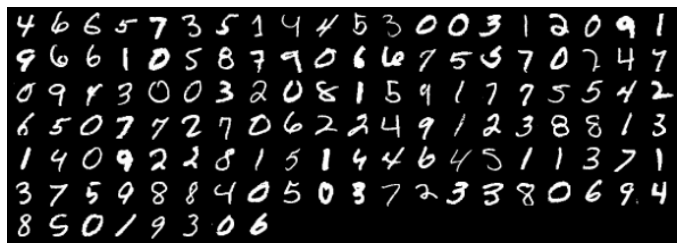

In [ ]:
#@title Plot a few examples taken from the dataset
sample = next(iter(mnist_dataloader))[:20]
imgs,labels = sample
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
#@title We used a batch size of 500 (Since we use 2 batches, we need at first to sample 2*500 images).
dataset_batch_size = 1000
batches_per_epoch = int(len(mnist_dataset)/dataset_batch_size)

In [ ]:
#@title Function to train the model
def train_model(model, n_epochs, verbose, dataloader, device, save_path, n_discrim =3 , batch_size = 500, label =True, input_size = 100, new_ckpt = 10):
  '''train OT-GAN model
  model : OT-GAN model
  n_epochs : number of epochs for which to train model
  verbose : if set to True, print loss after each epoch
  dataloader : training dataloader
  device : cpu or gpu
  save_path : path used to save checkpoints weights
  n_discrim : after how many generator training steps to train the discriminator
  batch_size : batch size of each batch used to train the model (size of each of the 4 batches)
  label : set to True if dataloader returns a tensor and labels (to only keep img labels)
  nb_channels : number of channels of the image used for training
  '''
  
  model = model.to(device)
  losses_list = []#Store average epoch losses
  z = (2*torch.rand(40, 100)-1).to(device)
  for i in tqdm(range(n_epochs)):
    avg_loss = 0#avg epoch loss
    count_ = 0#Number of images treated (to get average loss)
    for current,x in enumerate(dataloader):
      if label :#Only keep images
        x = x[0]
        
      x = x.to(device)
      
      first_real_batch = (x[:batch_size]).to(device)#first batch of real images
      second_real_batch = (x[batch_size:2*batch_size]).to(device)#Second batch of real images
      input_noise = (2*torch.rand(2*batch_size, input_size)-1).to(device)#Noise from which to generate images
      output_imgs = model(input_noise)
         
      first_gen_batch = (output_imgs[:batch_size])#first batch of generated images
      second_gen_batch = (output_imgs[batch_size:])#second batch of generated images
         
      first_gen_batch = first_gen_batch.to(device)
      second_gen_batch = second_gen_batch.to(device)
      
      if current % n_discrim == 1:#check if we train discriminator
        discrim = True
        optimizer = model.init_optimizers()[1]#discriminator optimizer
      else:
        discrim = False
        optimizer = model.init_optimizers()[0]#generator optimizer
      optimizer.zero_grad()#zero gradient
      loss = model.loss_fct(first_gen_batch, second_gen_batch, first_real_batch, second_real_batch, discrim)
      loss.backward()
      optimizer.step()
      avg_loss += loss.item()
      count_ += batch_size
        
    if verbose :
      print("Average epoch loss is", round(avg_loss/count_,5))
      if i%10==9:
        # Print some generated images
        with torch.no_grad():
          imgs = model(z).detach().cpu()
        plt.figure(figsize=(12,12))
        plt.axis("off")
        grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).numpy()
        plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray')
        plt.show()
    temp_save_path = save_path + str(i//new_ckpt) +".pth"
    torch.save(model.state_dict(), temp_save_path)
    losses_list.append(avg_loss/count_)
  return losses_list

In [ ]:
#@title paths under which to save weights and losses
save_path = "ckpt_ot"
losses_save_path = "mod_ot_losses.pickles"

  0%|          | 0/100 [00:00<?, ?it/s]

Average epoch loss is 0.00187
Average epoch loss is 0.00032
Average epoch loss is 0.00025
Average epoch loss is 0.00028
Average epoch loss is 0.00025
Average epoch loss is 0.00025
Average epoch loss is 0.00029
Average epoch loss is 0.00035
Average epoch loss is 0.00033
Average epoch loss is 0.00033


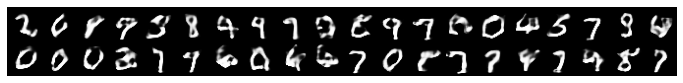

Average epoch loss is 0.00032
Average epoch loss is 0.00028
Average epoch loss is 0.00033
Average epoch loss is 0.00032
Average epoch loss is 0.00036
Average epoch loss is 0.00024
Average epoch loss is 0.00045
Average epoch loss is 0.00027
Average epoch loss is 0.00031
Average epoch loss is 0.00034


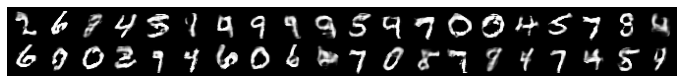

Average epoch loss is 0.00048
Average epoch loss is 0.00017
Average epoch loss is 0.00033
Average epoch loss is 0.00029
Average epoch loss is 0.00033
Average epoch loss is 0.00028
Average epoch loss is 0.00023
Average epoch loss is 0.00043
Average epoch loss is 0.00037
Average epoch loss is 0.00032


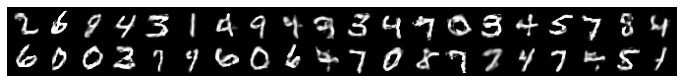

Average epoch loss is 0.00029
Average epoch loss is 0.00033
Average epoch loss is 0.00045
Average epoch loss is 0.00028
Average epoch loss is 0.0003
Average epoch loss is 0.00029
Average epoch loss is 0.00031
Average epoch loss is 0.00025
Average epoch loss is 0.00024
Average epoch loss is 0.00026


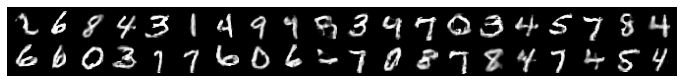

Average epoch loss is 0.00017
Average epoch loss is 0.00024
Average epoch loss is 0.00039
Average epoch loss is 0.00027
Average epoch loss is 0.00024
Average epoch loss is 0.00014
Average epoch loss is 0.00012
Average epoch loss is 0.00021
Average epoch loss is 0.00017
Average epoch loss is 0.00019


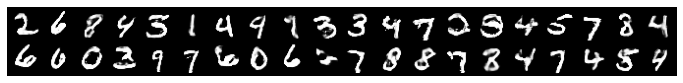

Average epoch loss is 0.00013
Average epoch loss is 0.00013
Average epoch loss is 0.0001
Average epoch loss is 0.00021
Average epoch loss is 9e-05
Average epoch loss is 7e-05
Average epoch loss is 4e-05
Average epoch loss is 5e-05
Average epoch loss is 7e-05
Average epoch loss is 9e-05


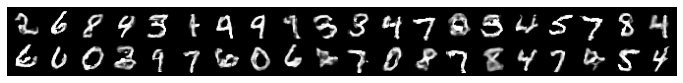

Average epoch loss is 0.00012
Average epoch loss is 7e-05
Average epoch loss is 9e-05
Average epoch loss is 0.00011
Average epoch loss is 0.00014
Average epoch loss is 0.00014
Average epoch loss is 0.00011
Average epoch loss is 4e-05
Average epoch loss is 7e-05
Average epoch loss is 7e-05


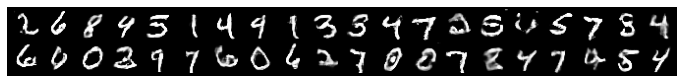

Average epoch loss is 0.0001
Average epoch loss is 0.00011
Average epoch loss is 8e-05
Average epoch loss is 9e-05
Average epoch loss is 0.00013
Average epoch loss is 0.00013
Average epoch loss is 0.00015
Average epoch loss is 0.0001
Average epoch loss is 0.0001
Average epoch loss is 8e-05


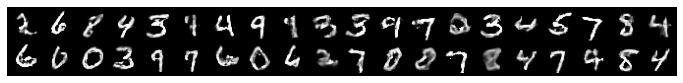

Average epoch loss is 0.0001
Average epoch loss is 0.00012
Average epoch loss is 6e-05
Average epoch loss is 0.00011
Average epoch loss is 0.00011
Average epoch loss is 8e-05
Average epoch loss is 7e-05
Average epoch loss is 7e-05
Average epoch loss is 7e-05
Average epoch loss is 9e-05


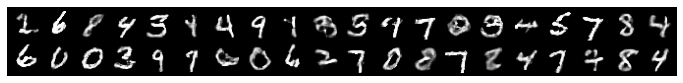

Average epoch loss is 7e-05
Average epoch loss is 6e-05
Average epoch loss is 0.00012
Average epoch loss is 0.0001
Average epoch loss is 6e-05
Average epoch loss is 6e-05
Average epoch loss is 5e-05
Average epoch loss is 6e-05
Average epoch loss is 9e-05
Average epoch loss is 8e-05


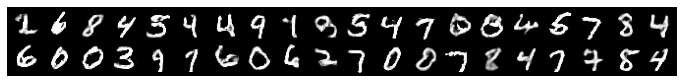

In [ ]:
#@title Train model for 100 epochs
model = OT_GAN(device)
losses = train_model(model, 100, True, mnist_dataloader, device, save_path)

with open(losses_save_path,"wb") as f:
  pickle.dump(losses,f)

We plot below the evolution of our training loss over 100 training epochs. 

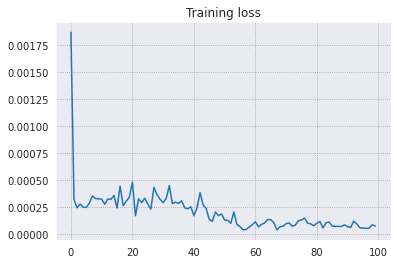

In [ ]:
#@title Evolution of training loss per epoch
sns.lineplot(x=range(100),y=losses)
plt.title("Training loss")
plt.show()

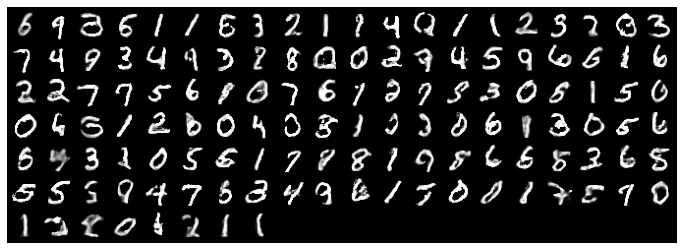

In [ ]:
#@title Image generation using our trained model
imgs = model((2*torch.rand(128, 100)-1).to(device))
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

#Previous attemps

We tried different model architectures when building our Optimal Transport enhanced GAN. It was difficult to judge whether failures were due to an unsuitable architecture, or to unstable training. Nevertheless, what seemed to work the best was to have a convolutionnal based generator and a discriminator made of stacked linear layers.

At some point, we also switched from standard gaussian input noise to uniform input noise in [-1,1], and it seemed to have helped getting better results.

Below we plot the results of a few of our attemps

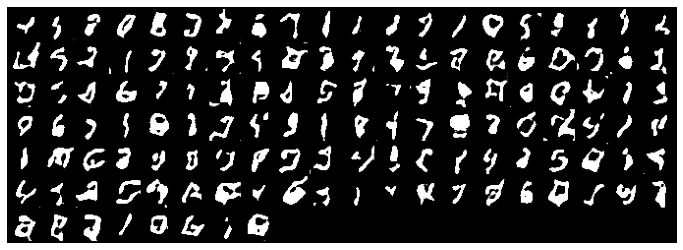

In [ ]:
#@title Convolution for both generator and discriminator (2 conv layers for discriminator)
#imgs = model((2*torch.rand(128, 100)-1).to(device))
#plt.figure(figsize=(12,12))
#plt.axis("off")
#grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
#plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

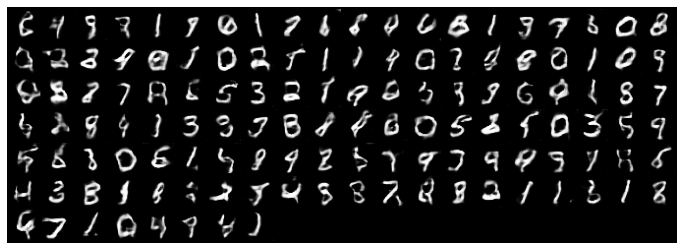

In [ ]:
#@title Convolutionnal discriminator and generator (4 conv layers for discriminator)
#imgs = model((2*torch.rand(128, 100)-1).to(device))
#plt.figure(figsize=(12,12))
#plt.axis("off")
#grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
#plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

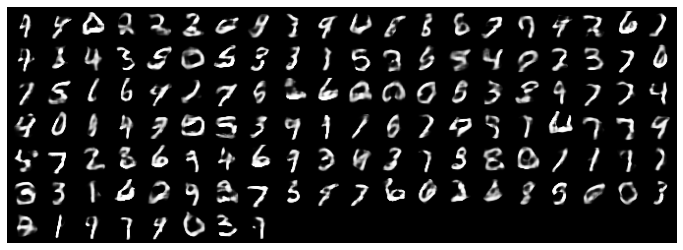

In [ ]:
#@title Convolutionnal generator, linear discriminator (3 linear layers)
#imgs = model((2*torch.rand(128, 100)-1).to(device))
#plt.figure(figsize=(12,12))
#plt.axis("off")
#grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
#plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

#We also tried to generate single digits. Below we plot the generated images for the digits 2 and 8.

Instead of generating images of digits ranging from 0 to 9, we tried training different models to generate images of a single digit (one model per digit).

When training a model to generate images of a single digit the results were very satisfying. This was to be expected as we can assume that the distribution of images of a single digit is easier to learn than the distribution of all digits.

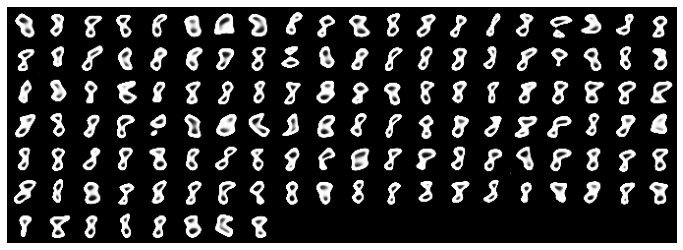

In [ ]:
#@title Image generation of digit 8
#imgs = model((2*torch.rand(128, 100)-1).to(device))
#plt.figure(figsize=(12,12))
#plt.axis("off")
#grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
#plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

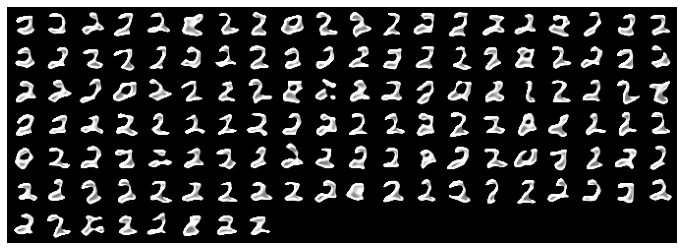

In [ ]:
#@title Image generation of digit 2
#imgs = model((2*torch.rand(128, 100)-1).to(device))
#plt.figure(figsize=(12,12))
#plt.axis("off")
#grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
#plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

#Classical GANS

Since we wanted to fathom the effect of adding Optimal transport to GANS, we also tried to build and train a classical GAN model which has an architecture similar to the architecture of the Optimal transport based gans tested.

In [ ]:
#@title New  dataloader with lower batch size
gan_mnist_dataloader = DataLoader(mnist_dataset, batch_size = 64, shuffle=True, drop_last=True)

Below a GAN with a generator and discriminator architectures close to Optimal Transport enhanced GANS architecture : a convolutionnal based generator, and linear based discriminator

In [ ]:
#@title Classical GAN
class GAN(nn.Module):
  '''Class to Implement Optimal Transport enhance GAN'''

  def __init__(self,  input_img_channels = 1, gen_feature_channels = [16,128,64,32], hidden_embed = 128, embedding_size = 256, input_size = 100, output_size = 32):
    
    super().__init__()
    
    self.gen_feature_channels = gen_feature_channels
    self.output_size = output_size
    
    #Sinkhorn divergence parameters
    
    #Generator layers
    self.gfc=nn.Linear(input_size, (output_size+8)*(output_size+8)*gen_feature_channels[0])
    self.gconv1 = nn.Conv2d(gen_feature_channels[0], gen_feature_channels[1],3)
    self.gconv2 = nn.Conv2d(gen_feature_channels[1], gen_feature_channels[2], 3)
    self.gconv3 = nn.Conv2d(gen_feature_channels[2], gen_feature_channels[3], 3)
    self.gconv4 = nn.Conv2d(gen_feature_channels[3], input_img_channels, 3)

    
    #Discriminator layers
    self.fc1 = nn.Linear(output_size*output_size, hidden_embed )
    self.fc2 = nn.Linear(hidden_embed,embedding_size)
    self.fc3 = nn.Linear(embedding_size,2)

    #Activation related functions
    self.gbnorm1 = nn.BatchNorm1d((output_size+8)*(output_size+8)*gen_feature_channels[0])
    self.gbnorm2 = nn.BatchNorm2d(gen_feature_channels[1])
    self.gbnorm3 = nn.BatchNorm2d(gen_feature_channels[2])
    self.gbnorm4 = nn.BatchNorm2d(gen_feature_channels[3])



    self.dbnorm1 = nn.BatchNorm1d(hidden_embed)
    self.dbnorm2 = nn.BatchNorm1d(embedding_size)


    self.relu = nn.ReLU()
    self.gelu = nn.GELU()
    self.softmax = nn.Softmax(dim = 1)
    self.sigmoid = nn.Sigmoid()

    #Loss function
    self.criterion = nn.CrossEntropyLoss()

  #######################################
  #return optimizers
  #######################################
  def init_optimizers(self):
    '''Define optimizer (outside of __init__ in case we import weights)'''
    self.generator_optimizer = torch.optim.Adam([{"params" : self.gfc.parameters()},
                                                 {"params" : self.gconv1.parameters()},
                                                 {"params" : self.gconv2.parameters()},
                                                 {"params" : self.gconv3.parameters()},
                                                 {"params" : self.gconv4.parameters()}])
    
    self.discrim_optimizer = torch.optim.Adam([{"params" : self.fc1.parameters()},
                                               {"params" : self.fc2.parameters()},
                                               {"params" : self.fc3.parameters()}])
    
    return(self.generator_optimizer,self.discrim_optimizer)


  def discriminator(self, x):
    '''Discrimnator'''
    
    flatten_x = torch.flatten(x,start_dim = 1)
    
    h1 = self.fc1(flatten_x)
    h1 = self.dbnorm1(h1)
    h1 = self.relu(h1)
    
    h2 = self.fc2(h1)
    h2 = self.dbnorm2(h2)
    h2 = self.relu(h2)

    h3 = self.fc3(h2)

    return(h3)
    

  def forward(self,x):
    '''Apply generator to noise  vector
    x : noise vector'''



    h1 = self.gfc(x)
    h1 = self.gbnorm1(h1)
    h1 = self.gelu(h1)
    h1 = h1.view(-1,self.gen_feature_channels[0], self.output_size+8, self.output_size+8)

    
    h2 = self.gconv1(h1)
    h2 = self.gbnorm2(h2)
    h2 = self.relu(h2)

    h3 = self.gconv2(h2)
    h3 = self.gbnorm3(h3)
    h3 = self.relu(h3)

    h4 = self.gconv3(h3)
    h4 = self.gbnorm4(h4)
    h4 = self.relu(h4)

    h5 = self.gconv4(h4)
    h5 = self.sigmoid(h5)

    return(h5)


In [ ]:
#@title Function to train the model
def train_model(model, n_epochs, verbose, dataloader, device, save_path, batch_size = 64 , label =True, input_size = 100, new_ckpt = 10):
  '''train OT-GAN model
  model : OT-GAN model
  n_epochs : number of epochs for which to train model
  verbose : if set to True, print loss after each epoch
  dataloader : training dataloader 
  device : cpu or gpu
  save_path : path used to save checkpoints weights
  batch_size : batch size of each batch used to train the model (size of each of the 4 batches)
  label : set to True if dataloader returns a tensor and labels (to only keep img labels)
  nb_channels : number of channels of the image used for training
  '''
  
  model = model.to(device)
  gen_losses_list = []#Store average epoch losses
  discrim_losses_list = []

  gen_optimizer, discrim_optimizer =  model.init_optimizers()
  
  for i in tqdm(range(n_epochs)):
     
    avg_loss_discrim = 0#avg epoch loss
    avg_loss_gener = 0
    
    count_discrim = 0#Number of images treated (to get average loss)
    count_gener = 0
    
    for current,x in enumerate(dataloader):
      
      if i%2 == 0 : #On even epochs train discriminator
        if label:
          x = x[0]
        
        real_imgs = x.to(device)
        
        input_noise = torch.randn((batch_size, input_size )).to(device)#Noise from which to generate images
        fake_imgs = model(input_noise).to(device)

        concat_images = torch.cat((real_imgs, fake_imgs))
        labels = torch.cat((torch.ones(real_imgs.shape[0]), torch.zeros(fake_imgs.shape[0]) ))
        labels = labels.long().to(device)
        
        discrim_result = model.discriminator(concat_images).to(device)

        loss = -1*model.criterion(discrim_result, labels)
        
        avg_loss_discrim -= loss.item()
        count_discrim+= 2*batch_size
        
        discrim_optimizer.zero_grad()
        loss.backward()
        discrim_optimizer.step()

      else: #On odd epochs train generator
        
        input_noise = torch.randn((batch_size, input_size )).to(device)#Noise from which to generate images
        imgs = model(input_noise).to(device)
        discrim_result = model.discriminator(imgs).to(device)

        labels = torch.ones(batch_size).long().to(device)
        
        loss = model.criterion(discrim_result, labels)
        
        avg_loss_gener += loss.item()
        count_gener+= batch_size
        
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()


    if verbose :
      if i%2 == 0:
        print("Average discriminator epoch loss is", round(avg_loss_discrim/count_discrim,5))
        discrim_losses_list.append(avg_loss_discrim/count_discrim)
      else:
        print("Average generator epoch loss is", round(avg_loss_gener/count_gener,5))
        gen_losses_list.append(avg_loss_gener/count_gener)
    
    temp_save_path = save_path + str(i//new_ckpt) +".pth"
    torch.save(model.state_dict(), temp_save_path)
    
  return discrim_losses_list,gen_losses_list


In [ ]:
#@title Train model

losses = train_model(model, 20, True, gan_mnist_dataloader, device, save_path)

with open(losses_save_path,"wb") as f:
  pickle.dump(losses,f)

 10%|█         | 1/10 [01:04<09:42, 64.72s/it]

Average discriminator epoch loss is 5.70815


 20%|██        | 2/10 [02:10<08:42, 65.27s/it]

Average generator epoch loss is 1.62919


 30%|███       | 3/10 [03:15<07:34, 64.98s/it]

Average discriminator epoch loss is 9.46057


 40%|████      | 4/10 [04:20<06:31, 65.29s/it]

Average generator epoch loss is 2.48177


 50%|█████     | 5/10 [05:25<05:25, 65.03s/it]

Average discriminator epoch loss is 13.21287


 60%|██████    | 6/10 [06:31<04:21, 65.25s/it]

Average generator epoch loss is 3.22784


 70%|███████   | 7/10 [07:38<03:17, 65.91s/it]

Average discriminator epoch loss is 16.96496


 80%|████████  | 8/10 [08:44<02:11, 65.84s/it]

Average generator epoch loss is 3.77306


 90%|█████████ | 9/10 [09:49<01:05, 65.60s/it]

Average discriminator epoch loss is 20.71637


100%|██████████| 10/10 [10:54<00:00, 65.48s/it]

Average generator epoch loss is 4.5376


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


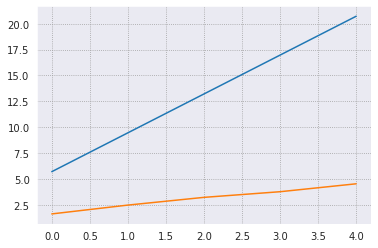

In [ ]:
#@title Evolution of training error
sns.lineplot(x=range(5), y=losses[0])
sns.lineplot(x=range(5), y=losses[1])
plt.show()

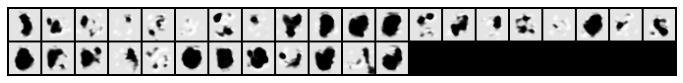

In [ ]:
#@title Image generation
imgs = model(torch.randn((32,100)))
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

Even though we may be able to discern on the images above some digits (represented by white pixels over gray background), we did not at all generate the expected images. 

This may be due to the fact that the generator and discriminator architectures are asymmetrical, whereas usually it seems that symmetrical architectures are preferred to build gans. 

Compared to this, even the worst results obtained using an optimal transport enhanced gan (for instance the results we showed above with convolutionnal generator and discriminator) are way better.

We only trained the model above for 10 epochs, but even after 10 epochs OT enhanced Gans gave better results. 

#Generate images using our weights

In [ ]:
#@title run this part to define functions and import packages
import torch
import torchvision
import pickle

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output 

!pip install torchinfo
clear_output()

from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


##############################################


class OT_GAN(nn.Module):
  '''Class to Implement Optimal Transport enhance GAN'''
  def __init__(self, device, input_img_channels = 1, gen_feature_channels = [8192, 256, 128, 64, 32], hidden_embed = 2048, cost_embedding_size = 4096,
               input_size = 100, output_size = 32, nb_steps_sinkhorn = 100, entropy_regularization = 500):
    
    super().__init__()
    
    # Added
    self.output_channels = 1
    self.kernel_size = 5
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    self.padding = int((self.kernel_size-1)/2)
    #
    
    self.device = device
    self.gdim = gen_feature_channels
    self.output_size = output_size
    
    #Generator layers
    self.gfc=nn.Linear(input_size, self.gdim[0])
    self.gconv1 = nn.Conv2d(self.gdim[1], self.gdim[1], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv2 = nn.Conv2d(self.gdim[2], self.gdim[2], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv3 = nn.Conv2d(self.gdim[3], self.gdim[3], kernel_size=self.kernel_size, stride=1, padding=self.padding)
    self.gconv4 = nn.Conv2d(self.gdim[4], self.output_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding)
    
    
    #Sinkhorn divergence parameters
    self.nb_steps = nb_steps_sinkhorn
    self.alpha = entropy_regularization

    
    #Learned cost function layers
    self.fc1 = nn.Linear(output_size*output_size, hidden_embed)
    self.fc2 = nn.Linear(hidden_embed,cost_embedding_size)
    self.cos_sim = torch.nn.CosineSimilarity(0)

    self.relu = nn.ReLU()
    self.glu = nn.GLU(dim=1)
    self.sigmoid = nn.Sigmoid()

  #######################################
  #return optimizers
  #######################################
  def init_optimizers(self):
    '''Define optimizer (outside of __init__ in case we import weights)'''
    self.generator_optimizer = torch.optim.Adam([{"params" : self.gfc.parameters()},
                                                 {"params" : self.gconv1.parameters()},
                                                 {"params" : self.gconv2.parameters()},
                                                 {"params" : self.gconv3.parameters()},
                                                 {"params" : self.gconv4.parameters()}],
                                               lr=0.0005,
                                               betas=(0.5, 0.999))
    
    self.discrim_optimizer = torch.optim.Adam([{"params" : self.fc1.parameters()},
                                               {"params" : self.fc2.parameters()}],
                                             lr=0.0005,
                                               betas=(0.5, 0.999))
    
    return(self.generator_optimizer,self.discrim_optimizer)


  #######################################
  #Pairwise cosine distance after embedding
  #######################################
  def embed_for_cost(self,x):
    '''Function to embed a batch of images and normalize result to compute cost function
    x : batch of images'''
    embed_x = torch.flatten(x,start_dim = 1)
    embed_x = self.fc1(embed_x)
    embed_x = self.relu(embed_x)
    embed_x = self.fc2(embed_x)

    normalized_embed_x = torch.nn.functional.normalize(embed_x, p=2)
    return(normalized_embed_x)
  
  
  def pw_cosine_distance(self, normalized_embedded_batch_x, normalized_embedded_batch_y):
   '''Given a batch of (normalized) vectors, compute the pairwise cosine distance between the vectors of the first batch and of the second batch
   embedded_batch_x : batch of 1d vectors
   embedded_batch_y : second batch of 1d vectors with which to compute pairwise cosine distance'''
   result = torch.mm(normalized_embedded_batch_x, normalized_embedded_batch_y.T)
   result *= -1 
   result += 1
   return result

  #######################################
  #Sinkhorn
  #######################################

  def sinkhorn(self,cost_matrix):
    '''Implement Sinkhorn's divergence algorithm for soft matching
    cost_matrix : cost matrix (between two batches)'''
    cloned_cost_matrix = cost_matrix.clone().detach()
    K = torch.exp(-cloned_cost_matrix/self.alpha)
    n = cost_matrix.shape[0]
    u = (torch.ones(n)/n).to(device)
    
    normalized_one_vector = (torch.ones(n)/n).to(device)

    v = normalized_one_vector / torch.matmul(K.T,u)

    for i in range(self.nb_steps) :
      u = normalized_one_vector / torch.matmul(K,v)
      v = normalized_one_vector / torch.matmul(K.T,u)
    
    transport_plan = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))

    return transport_plan
  

  #######################################
  #Compute OT distance between batches
  #######################################


  def loss_fct(self, x0, x1, y0, y1, discrim = False):
    '''Compute loss function between batches
    x0 and x1 : 2 batches of real images
    y. and y1 : 2 batches of generated images
    '''
    #First step, is to get normalized embedding of each of the batch images
    embed_x0 = self.embed_for_cost(x0)
    embed_x1 = self.embed_for_cost(x1)
    embed_y0 = self.embed_for_cost(y0)
    embed_y1 = self.embed_for_cost(y1)

    #Now, get pairwise cosine distance between the batches of interest
    cost_matrix_1 = self.pw_cosine_distance(embed_x0,embed_y0)
    cost_matrix_2 = self.pw_cosine_distance(embed_x0,embed_y1)
    cost_matrix_3 = self.pw_cosine_distance(embed_x1,embed_y0)
    cost_matrix_4 = self.pw_cosine_distance(embed_x1,embed_y1)
    cost_matrix_5 = self.pw_cosine_distance(embed_x0,embed_x1)
    cost_matrix_6 = self.pw_cosine_distance(embed_y0,embed_y1)
    
    #Get OT plan and compute distance for each pair of batches
    ot_plan_1 = self.sinkhorn(cost_matrix_1)
    dist_1 = torch.trace(torch.matmul(ot_plan_1, cost_matrix_1.T))

    ot_plan_2 = self.sinkhorn(cost_matrix_2)
    dist_2 = torch.trace(torch.matmul(ot_plan_2, cost_matrix_2.T))

    ot_plan_3 = self.sinkhorn(cost_matrix_3)
    dist_3 = torch.trace(torch.matmul(ot_plan_3, cost_matrix_3.T))

    ot_plan_4 = self.sinkhorn(cost_matrix_4)
    dist_4 = torch.trace(torch.matmul(ot_plan_4, cost_matrix_4.T))

    ot_plan_5 = self.sinkhorn(cost_matrix_5)
    dist_5 = torch.trace(torch.matmul(ot_plan_5, cost_matrix_5.T))

    ot_plan_6 = self.sinkhorn(cost_matrix_6)
    dist_6 = torch.trace(torch.matmul(ot_plan_6, cost_matrix_6.T))



    loss = dist_1 + dist_2 + dist_3 + dist_4 -2*dist_5 -2*dist_6

    if discrim :
      loss = -1*loss
    return loss

  #######################################
  #generator 
  #######################################
  def forward(self,x):
    '''Apply generator to noise  vector
    x : noise vector'''

    h1 = self.gfc(x)
    #h1 = self.gbnorm1(h1)
    h1 = self.glu(h1)
    h1 = h1.view(-1, self.gdim[1], 4, 4)
    h1 = self.upsample(h1)
    
    #print(h1.size())
    h2 = self.gconv1(h1)
    #h2 = self.gbnorm2(h2)
    h2 = self.glu(h2)
    h2 = self.upsample(h2)
    
    
    h3 = self.gconv2(h2)
    #h3 = self.gbnorm3(h3)
    h3 = self.glu(h3)
    h3 = self.upsample(h3)

    h4 = self.gconv3(h3)
    #h4 = self.gbnorm4(h4)
    h4 = self.glu(h4)

    h5 = self.gconv4(h4)
    h5 = self.sigmoid(h5)

    return(h5)

In [ ]:
#@title Download weights and defined model
!gdown https://drive.google.com/uc?id=1Bcop0YKlZ5j6xNmz3zFYQJruHfwcFqKU


model = OT_GAN(device)
model.load_state_dict(torch.load("/content/ckpt_ot9.pth",map_location=torch.device(device)))

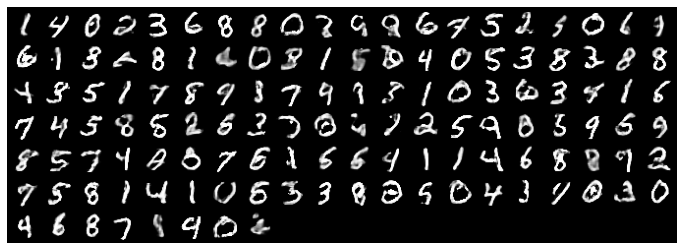

In [ ]:
#@title generate images
imgs = model((2*torch.rand(128, 100)-1).to(device))
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs).detach().cpu().numpy()
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');